# MINI PROJECT FUNDAMENTAL ML - Nhóm 4CE

In this project, we aim to classify images by first using **Principal Component Analysis (PCA)** for dimensionality reduction. PCA helps in transforming the images into a lower-dimensional space while preserving as much variance as possible. After the dimensionality reduction, we will classify the images using a Machine Learning Model, specifically a **Multi-Layer Perceptron (MLP)**. Additionally, we plan to explore **Convolutional Neural Networks (CNN), Histogram of Oriented Gradients  (HOG)** as further work.

You can go to the url https://thangbuiq.github.io/NMMH-4CE for easily view of this file.

## Team Members

| Name         | Student ID                                | Responsibilities                                         |
|--------------|-------------------------------------|----------------------------------------------------------|
| Bui Quang Thang |  21280048 | Leader, ensure timely completion, integrating all parts of the project and compiling the final report |
| Le Vo Bao Tram   |  21280052 | Handle EDA for each label, apply XgBoost, MLP and Naive Bayes classification |
| Huynh Thi Thu Thoang   | 21280074  | Apply Random Forest, MLP classification and compare before and after PCA  performance |
| Nguyen Thuy Vy | 21280120 | GridSearchCV to DecisionTree as e.g, implement model pipeline and handle SVM classification | 

## Methodology tl;dr

- Feature Engineering: PCA to reduce the dimensionality while preserving variance (95% cut-off)
- Core ML Algos: Multi-Layer Perceptron (MLP), Random Forest, XgBoost,... and PCA comparison
- Further work: Convolutional Neural Networks (CNN) for improved classification accuracy

## Libraries and functions that we used

In [1]:
# we ignore all warns because some modules of scikit lib are deprecated
import os
import warnings
warnings.filterwarnings("ignore")

# basic data libs to manipulate and visualize
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import time # to measure time training before and after pca
import pickle # dump and load model to save training time

# machine learning stuffs
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neural_network import MLPClassifier
from collections import OrderedDict


def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def show_img_label(images: np.ndarray, labels: np.ndarray, target_label: int = 0):
    # Filter images and labels based on the target label
    target_images = images[labels == target_label]
    target_labels = labels[labels == target_label]
    
    # Limit the number of images to 5 for display
    num_images = min(len(target_images), 5)
    
    _, axarr = plt.subplots(nrows=1, ncols=5, figsize=(18, 9))
    axarr = axarr.flatten()
    
    for idx in range(num_images):
        axarr[idx].imshow(target_images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(target_labels[idx]))
    
    # Hide any remaining subplots
    for idx in range(num_images, len(axarr)):
        axarr[idx].axis('off')
    
    plt.show()
    
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=1, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:5]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))
        
# visualize functions, will be use later
def plot_train_metrics(global_metrics):
    models = list(global_metrics.keys())
    train_accuracies = [global_metrics[model]['train_metrics'][0] for model in models]
    train_precisions = [global_metrics[model]['train_metrics'][1] for model in models]
    train_recalls = [global_metrics[model]['train_metrics'][2] for model in models]
    train_f1s = [global_metrics[model]['train_metrics'][3] for model in models]

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    x = np.arange(len(models)//2)
    width = 0.35

    axs[0].bar(x - width/2, train_accuracies[:len(x)], width, label='Original')
    axs[0].bar(x + width/2, train_accuracies[len(x):], width, label='PCA')
    axs[0].set_title('Train Accuracy Comparison')
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(models[:len(x)], rotation=45)
    axs[0].legend()

    axs[1].bar(x - width/2, train_precisions[:len(x)], width, label='Original')
    axs[1].bar(x + width/2, train_precisions[len(x):], width, label='PCA')
    axs[1].set_title('Train Precision Comparison')
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(models[:len(x)], rotation=45)
    axs[1].legend()

    axs[2].bar(x - width/2, train_recalls[:len(x)], width, label='Original')
    axs[2].bar(x + width/2, train_recalls[len(x):], width, label='PCA')
    axs[2].set_title('Train Recall Comparison')
    axs[2].set_xticks(x)
    axs[2].set_xticklabels(models[:len(x)], rotation=45)
    axs[2].legend()

    axs[3].bar(x - width/2, train_f1s[:len(x)], width, label='Original')
    axs[3].bar(x + width/2, train_f1s[len(x):], width, label='PCA')
    axs[3].set_title('Train F1-Score Comparison')
    axs[3].set_xticks(x)
    axs[3].set_xticklabels(models[:len(x)], rotation=45)
    axs[3].legend()

    plt.tight_layout()
    plt.show()

def plot_test_metrics(global_metrics):
    models = list(global_metrics.keys())
    test_accuracies = [global_metrics[model]['test_metrics'][0] for model in models]
    test_precisions = [global_metrics[model]['test_metrics'][1] for model in models]
    test_recalls = [global_metrics[model]['test_metrics'][2] for model in models]
    test_f1s = [global_metrics[model]['test_metrics'][3] for model in models]

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    x = np.arange(len(models)//2)
    width = 0.35

    axs[0].bar(x - width/2, test_accuracies[:len(x)], width, label='Original')
    axs[0].bar(x + width/2, test_accuracies[len(x):], width, label='PCA')
    axs[0].set_title('Test Accuracy Comparison')
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(models[:len(x)], rotation=45)
    axs[0].legend()

    axs[1].bar(x - width/2, test_precisions[:len(x)], width, label='Original')
    axs[1].bar(x + width/2, test_precisions[len(x):], width, label='PCA')
    axs[1].set_title('Test Precision Comparison')
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(models[:len(x)], rotation=45)
    axs[1].legend()

    axs[2].bar(x - width/2, test_recalls[:len(x)], width, label='Original')
    axs[2].bar(x + width/2, test_recalls[len(x):], width, label='PCA')
    axs[2].set_title('Test Recall Comparison')
    axs[2].set_xticks(x)
    axs[2].set_xticklabels(models[:len(x)], rotation=45)
    axs[2].legend()

    axs[3].bar(x - width/2, test_f1s[:len(x)], width, label='Original')
    axs[3].bar(x + width/2, test_f1s[len(x):], width, label='PCA')
    axs[3].set_title('Test F1-Score Comparison')
    axs[3].set_xticks(x)
    axs[3].set_xticklabels(models[:len(x)], rotation=45)
    axs[3].legend()

    plt.tight_layout()
    plt.show()

def plot_time_vs_performance(global_metrics):
    local_metrics = OrderedDict()
    for model in sorted(global_metrics):
        new_model_name = model.replace('Classifier', '')
        local_metrics[new_model_name] = global_metrics[model]

    models = list(local_metrics.keys())
    training_times = [local_metrics[model]['training_time'] for model in models]
    test_accuracies = [local_metrics[model]['test_metrics'][0] for model in models]
    test_precisions = [local_metrics[model]['test_metrics'][1] for model in models]
    test_recalls = [local_metrics[model]['test_metrics'][2] for model in models]
    test_f1s = [local_metrics[model]['test_metrics'][3] for model in models]

    fig, ax1 = plt.subplots(figsize=(12, 6))

    x = range(len(models))

    color = 'tab:red'
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Training Time (s)', color=color)

    ax1.bar(x, training_times, color=color, label='Training Time')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Performance Metrics', color=color)
    ax2.plot(x, test_accuracies, color='blue', marker='x', linestyle='dashed', label='Test Accuracy')
    ax2.plot(x, test_precisions, color='green', marker='x', linestyle='dashed', label='Test Precision')
    ax2.plot(x, test_recalls, color='orange', marker='x', linestyle='dashed', label='Test Recall')
    ax2.plot(x, test_f1s, color='purple', marker='x', linestyle='dashed', label='Test F1-Score')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper left')

    plt.title('Training Time vs Performance Metrics')
    fig.tight_layout()
    plt.show()

## 1. Overview of the problem to solve

In [2]:
df = pd.read_csv("../data/icml_face_data.csv")
display(df.head())
print(f"Dataframe shape: {df.shape}")

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


Dataframe shape: (35887, 2)


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

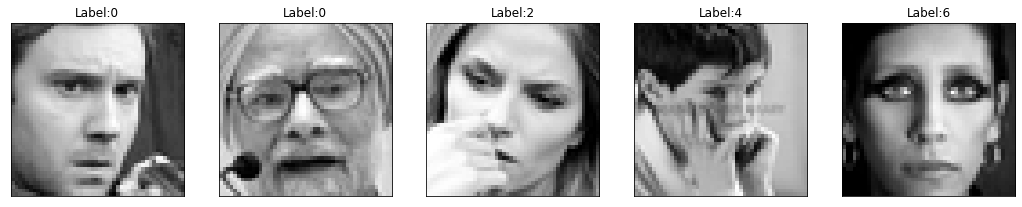

In [48]:
images, labels = parse_data(df)
show_img(images, labels)

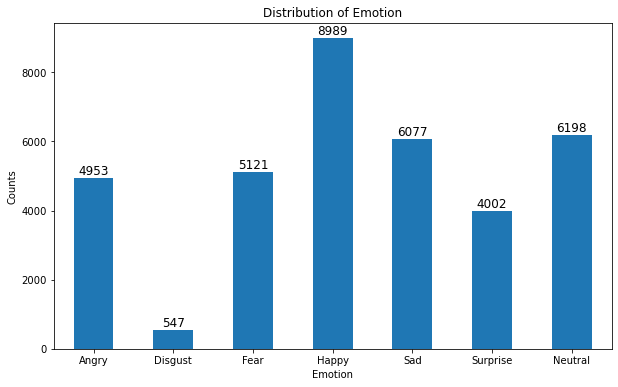

In [4]:
# storing emotion labels
label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

df1 = df.copy()

# calculating target distribution
td = df1["emotion"].value_counts().sort_index()

plt.figure(figsize=(10, 6))
ax = td.plot(kind='bar')
plt.title('Distribution of Emotion')
plt.xlabel('Emotion')
plt.ylabel('Counts')
plt.xticks(ticks=range(len(label_names)), labels=label_names, rotation=0)

for i, value in enumerate(td):
    plt.text(i, value + 100, str(value), ha='center', size=12)

plt.show()

1. **Happy**: The highest number of images (8989) were classified as "Happy".
2. **Disgust**: The "Disgust" category has the lowest count (547).
3. **Neutral**: A significant number of images (6198) were classified as "Neutral".
4. **Angry, Fear, Sad, Surprise**: These categories have moderate counts, with "Angry" at 4953, "Fear" at 5121, "Sad" at 6077, and "Surprise" at 4002, showing a varied distribution across different emotions.

$\rightarrow$ Imbalance data, accuracy of class 1 (Disgust) maybe low.

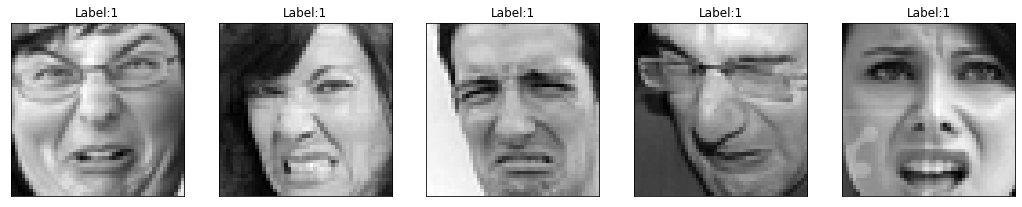

In [5]:
show_img_label(images, labels, target_label=1)

Okay, there's a proof that it's 100% that the label "1" represents for "Disgust". 🥸

## 2. Principle Component Analysis

Question 1: Can you visualize the data projected onto two principal components? (2 points)

In [6]:
def visualize_pca(images: np.ndarray, labels: np.ndarray):
    """
    Visualize the data projected onto two principal components
    """
    num_samples = images.shape[0]
    images_flatten = images.reshape(num_samples, -1)  # Each image becomes a row

    pca = PCA(n_components=2)
    images_pca = pca.fit_transform(images_flatten)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(images_pca[:, 0], images_pca[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Images')
    plt.show()

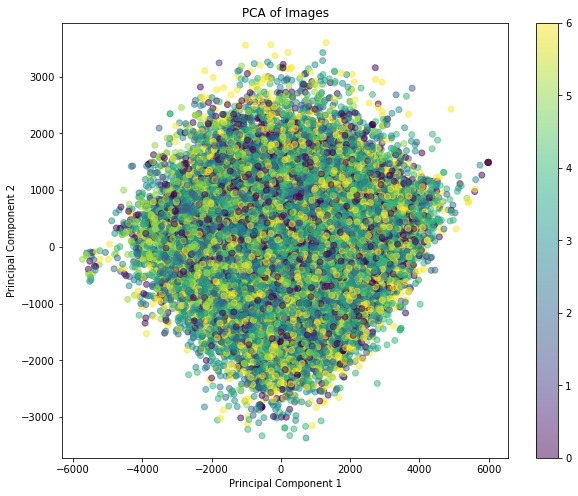

In [7]:
visualize_pca(images, labels)

* The PCA plot shows that the data is widely spread across the plane of the first two principal components.
* There are more data points in the center, indicating that many images have similar features.
* The data points are color-coded according to different expression labels, from 0 to 6. The color coding helps identify the distribution of expressions such as Angry, Disgust, Fear, Happy, Sad, Surprise, and Neutral.
* Even though there are some groups of similar colors, the expression labels overlap a lot. This means the first two principal components are not enough to fully separate the different expressions.
* To improve the classification of facial expressions, we may need to use more principal components or advanced methods like deep learning.

Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

$\rightarrow$ To efficiently reduce the dimensionality of our image data while retaining most of the variance, we used Principal Component Analysis (PCA). The following method determines the optimal number of PCA components needed to cover a specified threshold of the variance (95% in this case).

In [8]:
def determine_optimal_pca_components(images: np.ndarray, threshold: float = 0.95):
    n_samples, height, width = images.shape
    images_flat = images.reshape(n_samples, -1)

    pca = PCA()
    pca.fit(images_flat)

    # cut-off 95% variances coverages of PCA cumsum
    cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
    optimal_components = np.argmax(cumulative_explained_variance >= threshold) + 1

    return cumulative_explained_variance, optimal_components

cumulative_explained_variance, optimal_components = determine_optimal_pca_components(images, threshold=0.95)

In [9]:
print(f"Optimal number of principal components (threshold=0.95): {optimal_components}")

Optimal number of principal components (threshold=0.95): 255


So we should choose 255 as result, we can visualize to see why 255 is a good PCs number to choose:

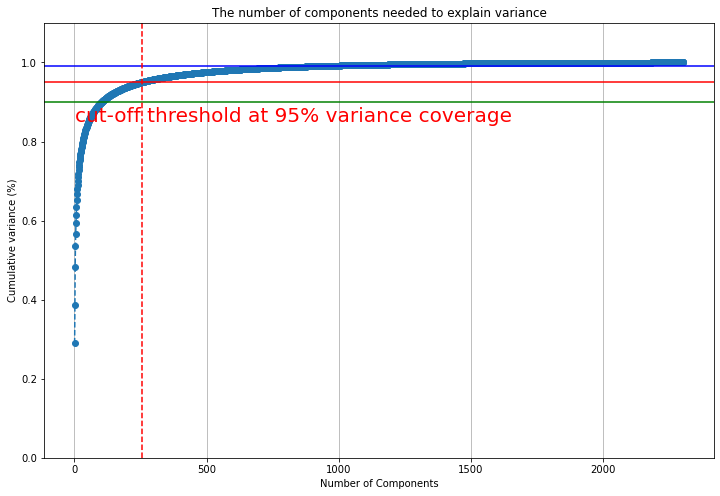

In [134]:
def plot_pca_variance(cumulative_variance, optimal_pcs):
    plt.rcParams["figure.figsize"] = (12,8)

    fig, ax = plt.subplots()
    xi = np.arange(1, len(cumulative_variance)+1, step=1)
    y = cumulative_variance

    plt.ylim(0.0,1.1)
    plt.plot(xi, y, marker='o', linestyle='--')

    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative variance (%)')
    plt.title('The number of components needed to explain variance')

    plt.axhline(y=0.90, color='g', linestyle='-')
    plt.axhline(y=0.95, color='r', linestyle='-')
    plt.axhline(y=0.99, color='b', linestyle='-')
    plt.text(0.5, 0.85, 'cut-off threshold at 95% variance coverage', color = 'red', fontsize=20)


    ax.grid(axis='x')
    plt.axvline(x=optimal_components, color='r', linestyle='--')
    plt.show()

plot_pca_variance(cumulative_explained_variance, optimal_components)

Our team chooses the 95% threshold in Principal Component Analysis (PCA) is common for these reasons:
* 95% of the data's total variance is kept, ensuring important information is not lost.
* Reducing the number of dimensions makes the model easier to work with and understand.
* Components beyond 95% often contain more noise than useful information, so they can be excluded.
* Using fewer components helps the model generalize better to new data, avoiding overfitting.


## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

In [5]:
def hog_algorithm(img_arrays):
    # initializing lists to collect hog feature descriptors (fd) and images
    fds = []
    # retrieving length of stacked image array
    array_length = len(img_arrays)
    # creating for loop to retrieve feature descriptors and hog images
    for i in range(array_length):
        fd = hog(img_arrays[i])
        fds.append(fd)
    fds = np.array(fds)
    return fds

- In image classification using traditional machine learning algorithms, the Histogram of Oriented Gradients (HOG) algorithm is valuable because it effectively captures the shape and structure of objects in images by focusing on gradients. 

- Unlike deep learning methods that require large amounts of labeled data and significant computational resources, HOG provides a computationally efficient way to extract meaningful features from images, making it suitable for scenarios where computational resources are limited or where deep learning frameworks are not applicable.

- In conlusion, we use "HOG" for "feature extraction", alongs with flatten the images.

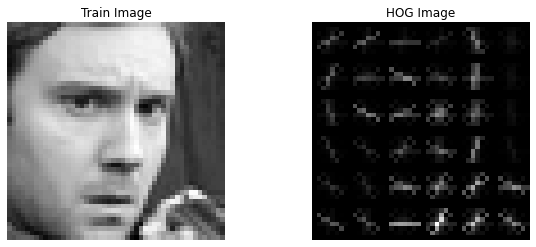

In [12]:
fd, hog_image = hog(images[0], visualize=True)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(images[0], cmap=plt.cm.gray)
plt.title('Train Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap=plt.cm.gray)
plt.title('HOG Image')
plt.axis('off')

# displaying plot
plt.show()

In [6]:
# pipeline build model without pca
def build_model(X, y, model):

    model = make_pipeline(
        model
    )

    model.fit(X,y)
    return model

# pipeline build model with pca
def build_model_pca(X, y, model):

    model = make_pipeline(
        PCA(n_components=optimal_components),
        model
    )

    model.fit(X,y)
    return model

global_metrics = {}

# report performance
def eval_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    return accuracy, precision, recall, f1

# full training pipeline to fit, predict, and evaluate metrics
def train_pipeline(images, labels, base_model, param_grid, pca=False, threshold=0.95):
    global global_metrics
    
    model_name = base_model.__class__.__name__
    pca_suffix = '_pca' if pca else ''
    model_filename = f"{model_name}{pca_suffix}_model.pkl"
    
    # Apply HOG algorithm to images
    hog_features = hog_algorithm(images)
    
    # Split data into training and test sets with test size = 20%
    X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=42)
    
    if os.path.exists(model_filename):
        # Load model if exists
        with open(model_filename, 'rb') as file:
            loaded_data = pickle.load(file)
            loaded_model, training_time, train_metrics, test_metrics = loaded_data
        print(f"----> Training time taken: {training_time} seconds")
        print(f"----> Test Data Metrics:")
        print(f"Accuracy: {test_metrics[0]:.4f}, Precision: {test_metrics[1]:.4f}, Recall: {test_metrics[2]:.4f}, F1-Score: {test_metrics[3]:.4f}")
        
        # Update global metrics to eval later
        global_metrics[f'{model_name}{pca_suffix}'] = {
            'training_time': training_time,
            'train_metrics': train_metrics,
            'test_metrics': test_metrics
        }
        
        return loaded_model
    else:
        if pca:
            model_pipeline = build_model_pca(X_train, y_train, base_model)
        else:
            model_pipeline = build_model(X_train, y_train, base_model)
        
    
        # GridSearchCV for other models
        grid_search_cv_model = GridSearchCV(
            model_pipeline, 
            param_grid,
            cv=2,  # k-fold = 2
            n_jobs=-1,
        )
        start_time = time.time()
        grid_search_cv_model.fit(X_train, y_train)
        training_time = time.time() - start_time
        print(f"----> Training time taken: {training_time} seconds")
        model_pipeline = grid_search_cv_model

        y_train_pred = model_pipeline.predict(X_train)
        train_metrics = eval_metrics(y_train, y_train_pred)
        # eval test
        y_test_pred = model_pipeline.predict(X_test)
        print("----> Test Data Metrics:")
        test_metrics = eval_metrics(y_test, y_test_pred)
        
        # dump model to save time
        with open(model_filename, 'wb') as file:
            pickle.dump((model_pipeline, training_time, train_metrics, test_metrics), file)
        
        global_metrics[f'{model_name}{pca_suffix}'] = {
            'training_time': training_time,
            'train_metrics': train_metrics,
            'test_metrics': test_metrics
        }
        
        return model_pipeline

In [51]:
param_grid_dt = {
    'decisiontreeclassifier__max_depth': [4, 6, 8, 10],
    'decisiontreeclassifier__min_samples_split': [2, 5, 10]
}

param_grid_svc = {
    'svc__kernel': ['poly'],
    'svc__C' : [1],
    'svc__degree': [6]
}

param_grid_rf = {
    'randomforestclassifier__n_estimators': [100, 200, 500],
    'randomforestclassifier__max_depth': [4, 8, 12]
}

param_grid_mlp = {
    'mlpclassifier__hidden_layer_sizes': [(48,)],
    'mlpclassifier__max_iter': [20]
}

# model we choose
classifiers = {
    'Decision Tree': (DecisionTreeClassifier(), param_grid_dt),
    'Random Forest': (RandomForestClassifier(), param_grid_rf),
    'SVM': (SVC(), param_grid_svc),
    'MLP': (MLPClassifier(verbose=True,max_iter=20), param_grid_mlp)
}

def trigger_pipelines(images=images, labels=labels, pca=False):
    if pca:
        print("ALL MODELS WILL GO THROUGH PCA BEFORE TRAINING")
        
    for model_name, (model, param_grid) in classifiers.items():
        print(f"====> Training {model_name} model...")
        train_pipeline(images, labels, model, param_grid, pca=pca)
        print("=====================================================================\n")

In [52]:
trigger_pipelines(pca=False)

====> Training Decision Tree model...
----> Training time taken: 30.40336513519287 seconds
----> Test Data Metrics:
Accuracy: 0.3096, Precision: 0.2848, Recall: 0.3096, F1-Score: 0.2835

====> Training Random Forest model...
----> Training time taken: 286.03959488868713 seconds
----> Test Data Metrics:
Accuracy: 0.4631, Precision: 0.5184, Recall: 0.4631, F1-Score: 0.4327

====> Training SVM model...
----> Training time taken: 1521.818505525589 seconds
----> Test Data Metrics:
Accuracy: 0.5671, Precision: 0.5716, Recall: 0.5671, F1-Score: 0.5665

====> Training MLP model...
----> Training time taken: 25.01947283744812 seconds
----> Test Data Metrics:
Accuracy: 0.4524, Precision: 0.4459, Recall: 0.4524, F1-Score: 0.4420



In [55]:
trigger_pipelines(pca=True)

ALL MODELS WILL GO THROUGH PCA BEFORE TRAINING
====> Training Decision Tree model...
----> Training time taken: 26.338268756866455 seconds
----> Test Data Metrics:
Accuracy: 0.3098, Precision: 0.2888, Recall: 0.3098, F1-Score: 0.2701

====> Training Random Forest model...
----> Training time taken: 91.44544196128845 seconds
----> Test Data Metrics:
Accuracy: 0.4078, Precision: 0.5361, Recall: 0.4078, F1-Score: 0.3601

====> Training SVM model...
----> Training time taken: 217.9067029953003 seconds
----> Test Data Metrics:
Accuracy: 0.3142, Precision: 0.7015, Recall: 0.3142, F1-Score: 0.2261

====> Training MLP model...
----> Training time taken: 26.85469388961792 seconds
----> Test Data Metrics:
Accuracy: 0.4734, Precision: 0.4612, Recall: 0.4734, F1-Score: 0.4615



- The **time taken** is **significantly higher for the original data** (for example, SVM takes 1500+ seconds for original but only 200 seconds for PCA data), suggesting that PCA reduces dimensionality but also speeds up computation.

- The model's performance metrics (accuracy, precision, recall, and F1-score) of PCA are generally lower compared to using the original data. 

- This trade-off is typical in machine learning tasks where dimensionality reduction sacrifices some predictive performance for computational efficiency. The choice between using PCA-transformed data or original data depends on the specific needs of your application: whether computational efficiency or model performance metrics are more critical.

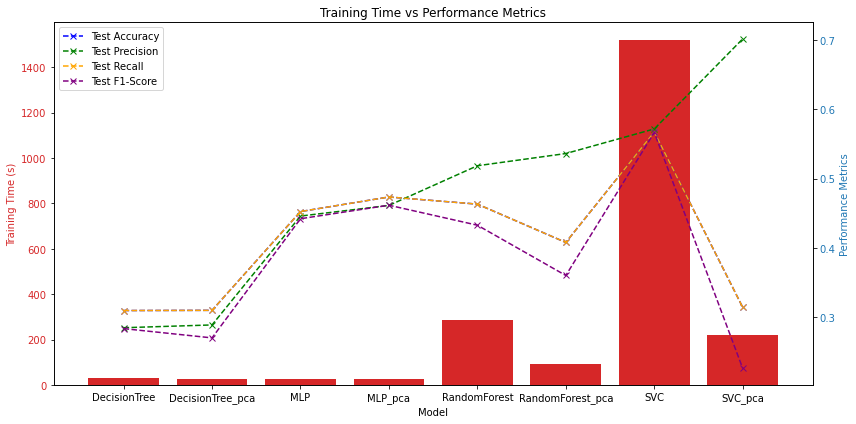

In [115]:
plot_time_vs_performance(global_metrics)

## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)

For this problem, the F1-score is the most appropriate metric to choose. This is because the F1-score balances both precision and recall, making it particularly useful in scenarios where class distributions are imbalanced, which is common in classification problems. Unlike accuracy, which can be misleading when there are significant class imbalances, the F1-score provides a more comprehensive evaluation by considering both false positives and false negatives, thus offering a better insight into the model's performance on minority classes.

loaded all trained models


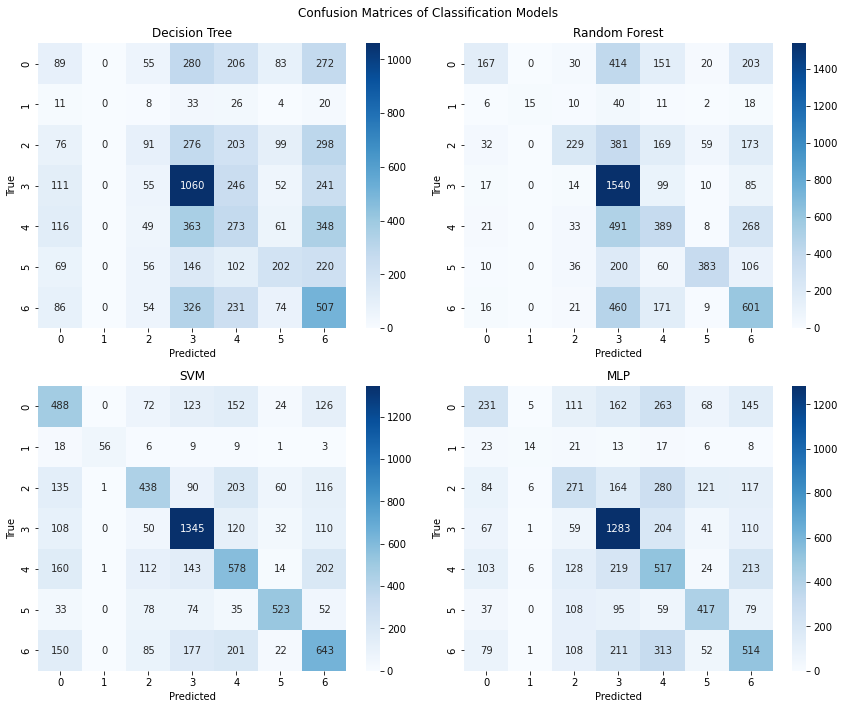

In [118]:
def load_models():
    models = []
    model_files = [
        'DecisionTreeClassifier_model.pkl',
        'RandomForestClassifier_model.pkl',
        'SVC_model.pkl',
        'MLPClassifier_model.pkl'
    ]
    
    for file in model_files:
        with open(file, 'rb') as f:
            models.append(pickle.load(f))
    
    model_names = ['Decision Tree', 'Random Forest', 'SVM', 'MLP']
    print("loaded all trained models")
    return models, model_names


def plot_confusion_matrix(ax, cm, title):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

hog_features = hog_algorithm(images)
_, X_test, _, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=42)
models, model_names = load_models()

# Create subplots for confusion matrices
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Confusion Matrices of Classification Models')

# Predict and plot confusion matrix for each model
for i, (model, model_name, ax) in enumerate(zip(models, model_names, axes.flatten())):
    trained_model = model[0]  # get trained model from tuple
    y_pred = trained_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(ax, cm, model_name)

plt.tight_layout()
plt.show()

- Support Vector Machine (SVM) is often considered the best model due to its effective use of the decision boundary, as evidenced by a well-structured confusion matrix. 

- However, it's worth noting that every model inaccurately predicts **class 1 (disgusted)** more frequently, as indicated by the lowest count in that cell of the confusion matrix.


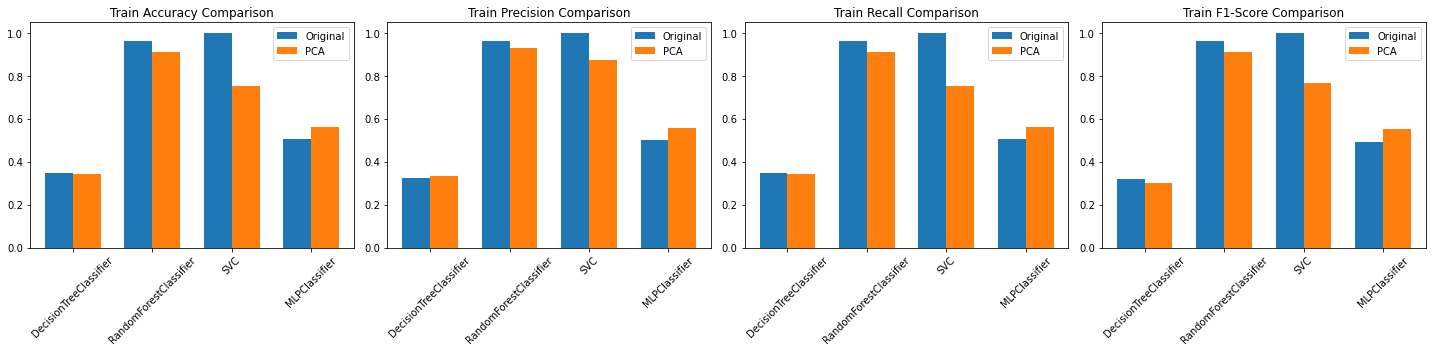

In [135]:
plot_train_metrics(global_metrics)

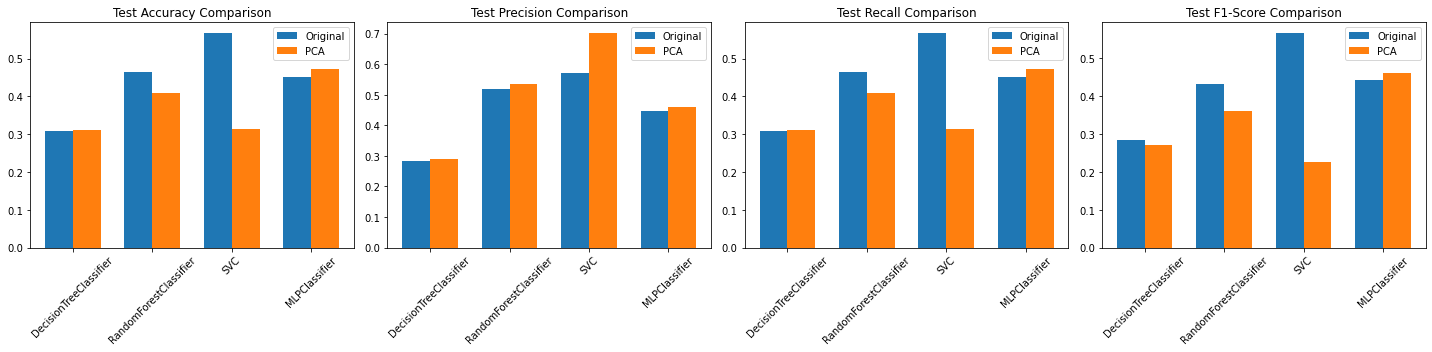

In [136]:
plot_test_metrics(global_metrics)

- Among the evaluated CLF modle, SVM is the top performer across both original and PCA-transformed datasets. It achieves the highest F1-score among all models. SVM's strong showing underscores its ability to effectively handle complex decision boundaries and generalize well to unseen data, as evidenced by its superior metrics compared to Decision Tree, Random Forest, and MLP models. 

- SVM's precision score on PCA-transformed data stands out, indicating its capability to correctly identify positive instances with minimal false positives. Overall, SVM proves to be the most reliable model for this classification task based on the provided evaluation metrics.

## 5. Further works (research the better solution)

### XGBoost

XGBoost is popular because it's very fast and efficient with large datasets like this. It's good at preventing overfitting and can handle missing data well.

In [7]:
hog_features = hog_algorithm(images)
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=42)
model = XGBClassifier()

start_time = time.time()
model.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Training time taken: {training_time:.2f} seconds")

Training time taken: 63.68 seconds


In [8]:
def calculate_performance(y_true, y_pred):
    report = classification_report(y_true, y_pred)
    print("Classification report:\n", report)

In [10]:
# Compare on training dataset
xgb_predY = model.predict(X_test)
calculate_performance(y_test, xgb_predY)

Classification report:
               precision    recall  f1-score   support

           0       0.41      0.34      0.37       985
           1       0.93      0.27      0.42       102
           2       0.44      0.33      0.38      1043
           3       0.60      0.76      0.67      1765
           4       0.38      0.42      0.39      1210
           5       0.71      0.59      0.64       795
           6       0.45      0.46      0.45      1278

    accuracy                           0.50      7178
   macro avg       0.56      0.45      0.48      7178
weighted avg       0.50      0.50      0.50      7178



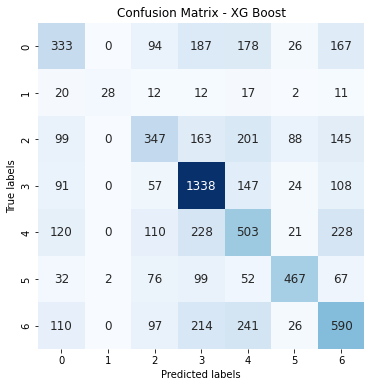

In [11]:
cm = confusion_matrix(y_test, xgb_predY)
class_names = np.unique(y_test)  

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 12}, square=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - XG Boost')
plt.show()

Nice try but still not better than SVM :) 

### CNN

CNNs excel in image classification tasks due to their ability to learn and hierarchically represent intricate patterns in images, their scalability to large datasets, and their proven effectiveness in achieving state-of-the-art performance across various domains.

In [19]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [46]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
import numpy as np

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128*6*6, 128)
        self.fc2 = nn.Linear(128, 7)  # 7 classes for emotions

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128*6*6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class EmotionDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].cpu().numpy() if isinstance(self.images[idx], torch.Tensor) else self.images[idx]
        image = image.astype(np.float32)
        image = (image - 127.5) / 127.5
        image = torch.from_numpy(image).unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

In [49]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

train_dataset = EmotionDataset(train_images, train_labels)
test_dataset = EmotionDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_images, batch_labels in train_loader:
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_images)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_images, batch_labels in test_loader:
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
            outputs = model(batch_images)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Test Accuracy: {accuracy:.2f}%')

print('Finished Training')


Epoch [1/30], Loss: 1.5818, Test Accuracy: 44.33%
Epoch [2/30], Loss: 1.3084, Test Accuracy: 50.92%
Epoch [3/30], Loss: 1.1735, Test Accuracy: 53.87%
Epoch [4/30], Loss: 1.0609, Test Accuracy: 57.17%
Epoch [5/30], Loss: 0.9511, Test Accuracy: 56.73%
Epoch [6/30], Loss: 0.8376, Test Accuracy: 57.44%
Epoch [7/30], Loss: 0.7138, Test Accuracy: 56.94%
Epoch [8/30], Loss: 0.5911, Test Accuracy: 55.59%
Epoch [9/30], Loss: 0.4873, Test Accuracy: 56.74%
Epoch [10/30], Loss: 0.3771, Test Accuracy: 56.97%
Epoch [11/30], Loss: 0.2942, Test Accuracy: 55.63%
Epoch [12/30], Loss: 0.2330, Test Accuracy: 56.53%
Epoch [13/30], Loss: 0.1805, Test Accuracy: 55.42%
Epoch [14/30], Loss: 0.1628, Test Accuracy: 55.89%
Epoch [15/30], Loss: 0.1240, Test Accuracy: 55.34%
Epoch [16/30], Loss: 0.1243, Test Accuracy: 55.74%
Epoch [17/30], Loss: 0.0997, Test Accuracy: 56.26%
Epoch [18/30], Loss: 0.0967, Test Accuracy: 55.89%
Epoch [19/30], Loss: 0.0982, Test Accuracy: 54.36%
Epoch [20/30], Loss: 0.0989, Test Accura

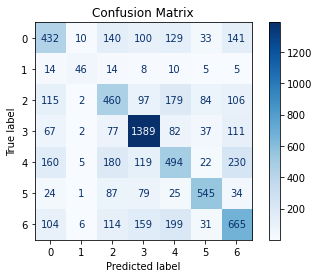

In [51]:
model.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
    for batch_images, batch_labels in test_loader:
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
        outputs = model(batch_images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [52]:
calculate_performance(all_labels, all_predictions)

Classification report:
               precision    recall  f1-score   support

           0       0.47      0.44      0.45       985
           1       0.64      0.45      0.53       102
           2       0.43      0.44      0.43      1043
           3       0.71      0.79      0.75      1765
           4       0.44      0.41      0.42      1210
           5       0.72      0.69      0.70       795
           6       0.51      0.52      0.52      1278

    accuracy                           0.56      7178
   macro avg       0.56      0.53      0.54      7178
weighted avg       0.56      0.56      0.56      7178



SVM still the best by just using Machine Learning and HOG algo to solve the result ==> reduce cost